# Bayesian Switchpoint Analysis

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Bayesian_Switchpoint_Analysis.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Bayesian_Switchpoint_Analysis.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

This notebook reimplements and extends the Bayesian “Change point analysis” example from the [pymc3 documentation](https://docs.pymc.io/notebooks/getting_started.html#Case-study-2:-Coal-mining-disasters).

## Prerequisites

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import edward2 as ed
tfd = tfp.distributions
tfb = tfp.bijectors
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,8)
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd

## Dataset

The dataset is from [here](https://pymc-devs.github.io/pymc/tutorial.html#two-types-of-variables). Note, there is another version of this example [floating around](https://docs.pymc.io/notebooks/getting_started.html#Case-study-2:-Coal-mining-disasters), but it has “missing” data – in which case you’d need to impute missing values. (Otherwise your model will not ever leave its initial parameters because the likelihood function will be undefined.)

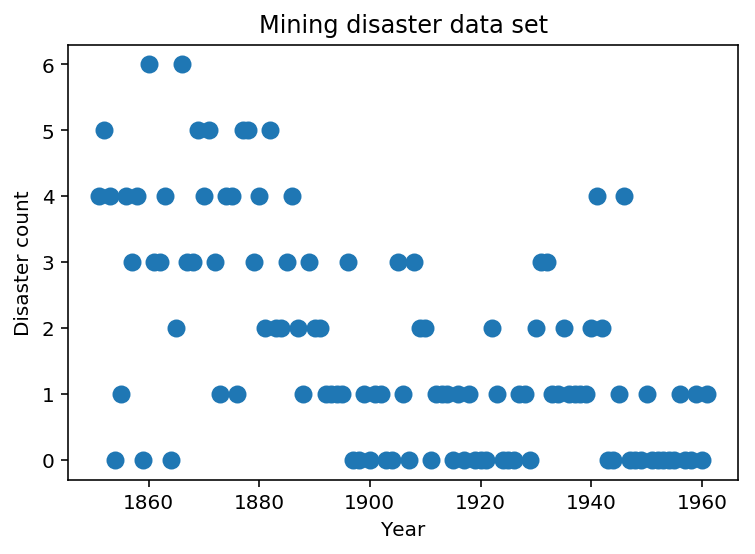

In [2]:
disaster_data = np.array([ 4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                           3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                           2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3, 0, 0,
                           1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                           0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                           3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                           0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])
years = np.arange(1851, 1962)
plt.plot(years, disaster_data, 'o', markersize=8);
plt.ylabel('Disaster count')
plt.xlabel('Year')
plt.title('Mining disaster data set')
plt.show()

## Probabilistic Model

The model assumes a “switch point” (e.g. a year during which safety regulations changed), and Poisson-distributed disaster rate with constant (but potentially different) rates before and after that switch point.

The actual disaster count is fixed (observed); any sample of this model will need to specify both the switchpoint and the “early” and “late” rate of disasters.

Original model from [pymc3 documentation example](https://pymc-devs.github.io/pymc/tutorial.html):


\begin{align*}
(D_t|s,e,l)&\sim \text{Poisson}(r_t), \\
  & \,\quad\text{with}\; r_t = \begin{cases}e & \text{if}\; t < s\\l &\text{if}\; t \ge s\end{cases} \\
s&\sim\text{Discrete Uniform}(t_l,\,t_h) \\
e&\sim\text{Exponential}(r_e)\\
l&\sim\text{Exponential}(r_l)
\end{align*}


However, the mean disaster rate $r_t$ has a discontinuity at the switchpoint $s$, which makes it not differentiable. Thus it provides no gradient signal to the Hamiltonian Monte Carlo (HMC) algorithm – but because the $s$ prior is continuous, HMC’s fallback to a random walk is good enough to find the areas of high probability mass in this example.

As a second model, we modify the original model using a [sigmoid “switch”](https://en.wikipedia.org/wiki/Sigmoid_function) between *e* and *l* to make the transition differentiable, and use a continuous uniform distribution for the switchpoint $s$.  (One could argue this model is more true to reality, as a “switch” in mean rate would likely be stretched out over multiple years.) The new model is thus:


\begin{align*}
(D_t|s,e,l)&\sim\text{Poisson}(r_t), \\
 & \,\quad \text{with}\; r_t = e + \frac{1}{1+\exp(s-t)}(l-e) \\
s&\sim\text{Uniform}(t_l,\,t_h) \\
e&\sim\text{Exponential}(r_e)\\
l&\sim\text{Exponential}(r_l)
\end{align*}


In the absence of more information we assume $r_e = r_l = 1$ as parameters for the priors. We’ll run both models and compare their inference results.

In [3]:
def disaster_count_model_switch():
  early_disaster_rate = ed.Exponential(rate=1., name='early_disaster_rate')
  late_disaster_rate = ed.Exponential(rate=1., name='late_disaster_rate')
  switchpoint = ed.Uniform(low=0., high=tf.to_float(len(years)),
                           name='switchpoint')
  def disaster_rate(ys):
    return [tf.where(y < switchpoint, early_disaster_rate, late_disaster_rate)
            for y in ys]
  disaster_count = ed.Poisson(rate=disaster_rate(np.arange(len(years))),
                              name='disaster_count')
  return disaster_count

def disaster_count_model_sigmoid():
  early_disaster_rate = ed.Exponential(rate=1., name='early_disaster_rate')
  late_disaster_rate = ed.Exponential(rate=1., name='late_disaster_rate')
  switchpoint = ed.Uniform(low=0., high=tf.to_float(len(years)),
                           name='switchpoint')
  def disaster_rate(ys):
    return (early_disaster_rate +
            tf.sigmoid((tf.to_float(ys)-switchpoint)) *
            (late_disaster_rate - early_disaster_rate))
  disaster_count = ed.Poisson(rate=disaster_rate(np.arange(len(years))),
                              name='disaster_count')
  return disaster_count


log_joint_switch = ed.make_log_joint_fn(disaster_count_model_switch)
log_joint_sigmoid = ed.make_log_joint_fn(disaster_count_model_sigmoid)


def target_log_prob_fn(log_joint, switchpoint, early_disaster_rate, late_disaster_rate):
  """
  Pass named parameters to log_joint function; disaster_count is the observed
  value hence receives the constant disaster_data.
  """
  named_args = {
      'switchpoint': switchpoint,
      'early_disaster_rate': early_disaster_rate,
      'late_disaster_rate': late_disaster_rate,
      'disaster_count': disaster_data,
  }
  return log_joint(**named_args)

The above code does three things:

1. Define the model via Edward distributions. The `disaster_rate` functions are called with an array of `[0, ..., len(years)-1]` to produce a vector of `len(years)` random variables – the years before the `switchpoint` are `early_disaster_rate`, the ones after `late_disaster_rate` (modulo the sigmoid transition).
1. Define the logprob function for the joint probability distribution. Each of the two function needs to be called with the four named parameters in the model and outputs the log probability of that outcome. (See below for an example.)
1. The `target_log_prob_fn` passes the variable elements of the model from the method arguments through to the joint probability function, and specifies the fixed (“observed”) outcomes directly. To avoid duplication and because the method signatures of both logprob functions are the same, we make `target_log_prob_fn` take the desired logprob function as first argument.

Here is a sanity-check that the target log prob function is sane:

In [4]:
with tf.Session() as sess:
  fs = [log_joint_switch, log_joint_sigmoid]
  print([target_log_prob_fn(f, 40., 3., .9).eval() for f in fs])  # Somewhat likely result
  print([target_log_prob_fn(f, 60., 1., 5.).eval() for f in fs])  # Rather unlikely result
  print([target_log_prob_fn(f, -10., 1., 1.).eval() for f in fs]) # Impossible result

[-176.94559, -176.28717]
[-371.3125, -366.8816]
[-inf, -inf]


## HMC to do Bayesian inference

We define the number of results and burn-in steps required; the code is mostly modeled after [the documentation of tfp.mcmc.HamiltonianMonteCarlo](https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc/HamiltonianMonteCarlo). It uses an adaptive step size (otherwise the outcome is very sensitive to the step size value chosen). We use values of one as the initial state of the chain.

This is not the full story though. If you go back to the model definition above, you’ll note that some of the probability distributions are not well-defined on the whole real number line. Therefore we constrain the space that HMC shall examine by wrapping the HMC kernel with a [TransformedTransitionKernel](https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc/TransformedTransitionKernel) that specifies the forward bijectors to transform the real numbers onto the domain that the probability distribution is defined on (see comments in the code below).

In [5]:
num_results = 10000
num_burnin_steps = 3000

def make_chain(i, target_log_prob):
  with tf.variable_scope("params", reuse=tf.AUTO_REUSE):
    step_size = tf.get_variable(
      name='step_size_model{}'.format(i),
      initializer=1.,
      trainable=False)
    step_size_adaptation_step_counter = tf.get_variable(
      name='step_size_adaptation_step_counter{}'.format(i),
      initializer=-1,
      dtype=tf.int32,
      trainable=False)

  states, _ = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=[
          # The three latent variables
          tf.ones([], name='init_switchpoint'),
          tf.ones([], name='init_early_disaster_rate'),
          tf.ones([], name='init_late_disaster_rate'),
      ],
      kernel=tfp.mcmc.TransformedTransitionKernel(
          inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=target_log_prob,
            step_size=step_size,
            step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(
              num_adaptation_steps=int(0.8*num_burnin_steps),
              step_counter=step_size_adaptation_step_counter),
            num_leapfrog_steps=3),
          bijector=[
              # The switchpoint is constrained between zero and len(years).
              # Hence we supply a bijector that maps the real numbers (in a
              # differentiable way) to the interval (0;len(yers))
              tfb.Chain([tfb.AffineScalar(scale=tf.to_float(len(years))),
                         tfb.Sigmoid()]),
              # Early and late disaster rate: The exponential distribution is
              # defined on the positive real numbers
              tfb.Softplus(),
              tfb.Softplus(),
          ]))
  return states

switchpoint, early_disaster_rate, late_disaster_rate = zip(
    make_chain(0, lambda *args: target_log_prob_fn(log_joint_switch, *args)),
    make_chain(1, lambda *args: target_log_prob_fn(log_joint_sigmoid, *args)))
switchpoint_, early_disaster_rate_, late_disaster_rate_ = (
    [None, None], [None, None], [None, None])

Run both models in parallel:

In [6]:
init_op = tf.global_variables_initializer()
with tf.Session() as sess:
  init_op.run()
  [
    switchpoint_[0], switchpoint_[1],
    early_disaster_rate_[0], early_disaster_rate_[1],
    late_disaster_rate_[0], late_disaster_rate_[1],
  ] = sess.run([
    switchpoint[0], switchpoint[1],
    early_disaster_rate[0], early_disaster_rate[1],
    late_disaster_rate[0], late_disaster_rate[1],
  ])

## Visualize the result

We visualize the result as histograms of samples of the posterior distribution for the early and late disaster rate, as well as the switchpoint. The histograms are overlaid with a solid line representing the sample median, as well as the 95%ile credible interval bounds as dashed lines.

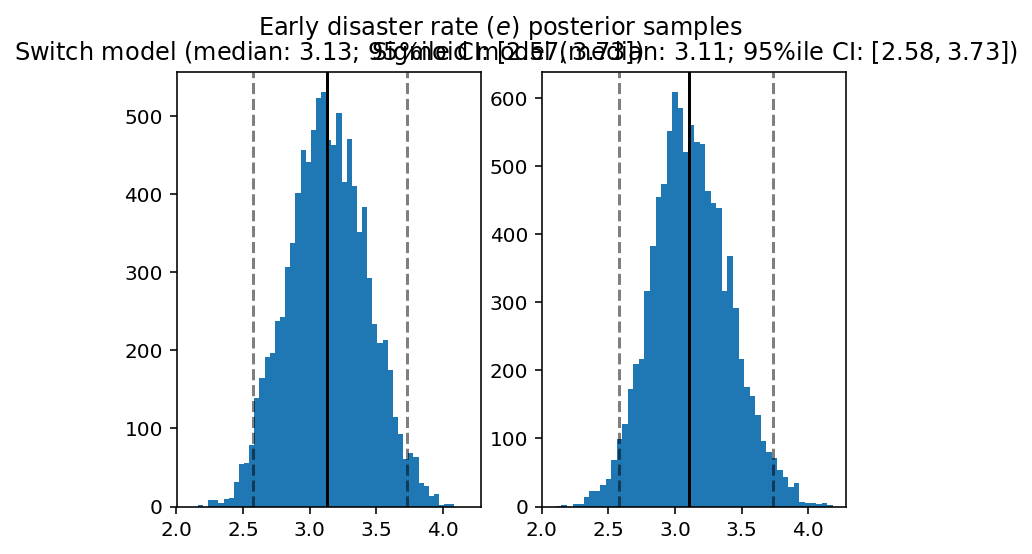

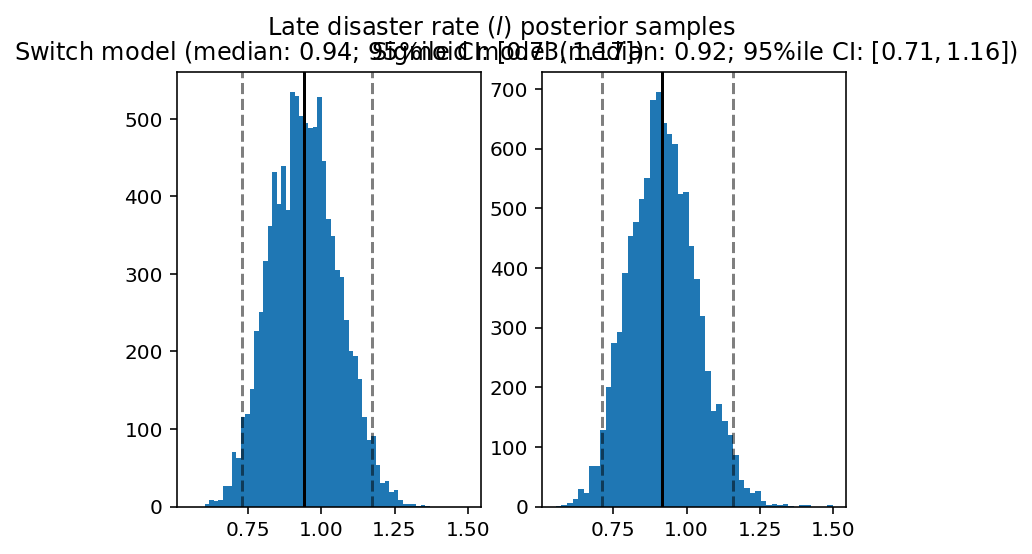

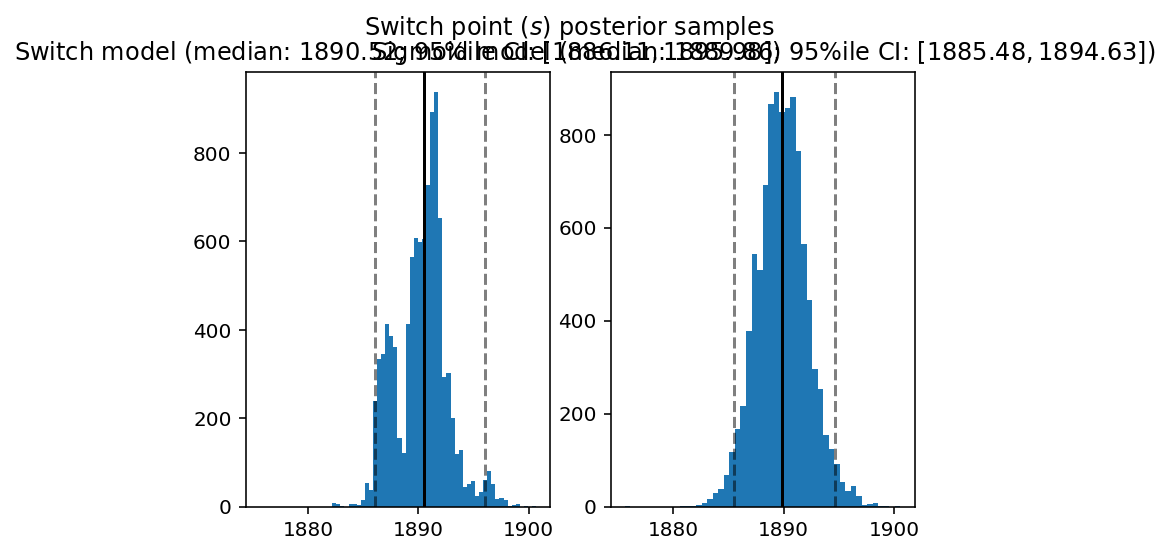

In [7]:
def _desc(v):
  return '(median: {}; 95%ile CI: $[{}, {}]$)'.format(
      *np.round(np.percentile(v, [50, 2.5, 97.5]), 2))

for t, v in [
    ('Early disaster rate ($e$) posterior samples', early_disaster_rate_),
    ('Late disaster rate ($l$) posterior samples', late_disaster_rate_),
    ('Switch point ($s$) posterior samples', years[0] + switchpoint_),
]:
  fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True)
  for (m, i) in (('Switch', 0), ('Sigmoid', 1)):
    a = ax[i]
    a.hist(v[i], bins=50)
    a.axvline(x=np.percentile(v[i], 50), color='k')
    a.axvline(x=np.percentile(v[i], 2.5), color='k', ls='dashed', alpha=.5)
    a.axvline(x=np.percentile(v[i], 97.5), color='k', ls='dashed', alpha=.5)
    a.set_title(m + ' model ' + _desc(v[i]))
  fig.suptitle(t)
  plt.show()